# 041 GDAL: time series

### Purpose

In this section, we'll continue to look at the MODIS LAI, with a view to forming a time series dataset. AT the end of this session, you will be able to generate a 3D numpy array of some MODIS geophysical variable for a selcted area and time.

### Prerequisites

* [030_NASA_MODIS_Earthdata](030_NASA_MODIS_Earthdata.ipynb)
* [031_Numpy](031_Numpy.ipynb)
* [032_more_numpy](032_More_numpy.ipynb)
* [040_GDAL_mosaicing_and_masking](040_GDAL_mosaicing_and_masking.ipynb)

You must make sure you can recall the details of the work covered in [040_GDAL_mosaicing_and_masking](040_GDAL_mosaicing_and_masking.ipynb). You will also need to know how to do [graph plotting](023_Plotting.ipynb), including sub-figures and errorbars, and [image display](024_Image_display.ipynb).

### Test

You should run a [NASA account test](004_Accounts.ipynb) if you have not already done so.

## Timeseries

We can conveniently generate a timeseries dataset using the `gdal` VRT file approach we used in [040_GDAL_mosaicing_and_masking](040_GDAL_mosaicing_and_masking.ipynb). 

In this case, the main process would be:

    - initialise band name list bnames
    - initialise list sds_set
    - loop over some set of doy values:
        - retrieve an SDS for each doy
        - make a band name for the doy/year
        - stitch tiles together into one VRT
        - append the new SDS to the list sds_set
        - append the band name to the list bnames

In [1]:
import gdal
from geog0111.modis import Modis

kwargs = {
    'tile'      :    ['h17v03','h18v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
year = 2019
# list of doys we want
# - every 4 days for MCD15A3H
doys = [41,45,49]

modis = Modis(**kwargs)

# initialise list sds_set
sds_set = []
bnames = []

# loop over some set of doy values:
for doy in doys:
    # retrieve an SDS for each doy
    files,sds = modis.get_files(year,doy)
    # choose only the first SDS for now
    this_sds = sds[0]
    
    # make a band name for the doy/year
    bandname = f'{year}-{doy:0>3d}'
    
    # stitch tiles together into one VRT
    # called ofile
    ofile = f"work/stitch_{modis.product}.{doy}.vrt"
    stitch_vrt = gdal.BuildVRT(ofile,this_sds)
    del stitch_vrt
    # append the new SDS to the list sds_set
    sds_set.append(ofile)
    # append the band name to the list bnames
    bnames.append(bandname)

print(sds_set)
print(bnames)

['work/stitch_MCD15A3H.41.vrt', 'work/stitch_MCD15A3H.45.vrt', 'work/stitch_MCD15A3H.49.vrt']
['2019-041', '2019-045', '2019-049']


Now we have a set of SDS we want to put them into a VRT file to represent the time series. We do this as we have previously, specifying the outoput name `work/stitch_set.vrt` here, and ythe listr of SDS that goes in to the time series,`sds_set` here:

In [2]:
# build a VRT "work/stitch_set.vrt"
stitch_vrt = gdal.BuildVRT("work/stitch_set.vrt", sds_set,separate=True)
del stitch_vrt
# test it by reading and plotting
g = gdal.Open("work/stitch_set.vrt")
data = g.ReadAsArray()
print(data.shape)

(3, 2400, 4800)


The dataset is now 3D. The first dimensions represent the time samples, so:

    data[0] -> bnames[0]
    
etc.

In [3]:
import numpy as np
for i in range(data.shape[0]):
    print(f'band {bnames[i]} -> mean {np.mean(data[i])}')

band 2019-041 -> mean 166.24298064236112
band 2019-045 -> mean 166.25176796875
band 2019-049 -> mean 165.74304947916667


#### Exercise 1

We have seen in [040_GDAL_mosaicing_and_masking](040_GDAL_mosaicing_and_masking.ipynb) that you can use `gdal` to creat a GeoTiff format image, for example with:

    g = gdal.Warp(output_name, input_name ,format='GTiff',options=['COMPRESS=LZW'])
    g.FlushCache()

* Convert the `gdal` file `work/stitch_set.vrt` to a more portable GeoTiff file called `work/stitch_set.tif`
* Confirm that this has worked by reading and displaying data from the file

Cut out the UK and visualise as before:

In [6]:
# subset and display

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='UK'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

g = gdal.Warp("", "work/stitch_set.vrt",**warp_args)
data = g.ReadAsArray()*0.1
print(data.shape)

(3, 2623, 1394)


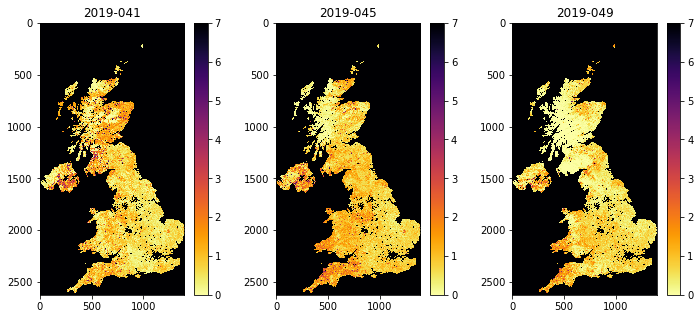

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize=(12,5))
axs = axs.flatten()
for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
    fig.colorbar(im, ax=axs[i])
    axs[i].set_title(bnames[i])

### `Modis.get_modis`

For convenience, we can again use the function `Modis.get_modis` to combine these, simply by passing a list of `doy` values, rather than a single `doy`.

In [8]:
import gdal
from geog0111.modis import Modis
import matplotlib.pyplot as plt

kwargs = {
    'tile'      :    ['h17v03','h18v03'],
    'product'   :    'MCD15A3H',
    'sds'       :    'Lai_500m',
}
year = 2019
# list of doys we want
doys = [41,45,49]

modis = Modis(**kwargs)

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='UK'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

mfiles = modis.get_modis(year,doys,warp_args=warp_args)
print(mfiles.keys())

dict_keys(['Lai_500m', 'bandnames'])


Now let's mask out invalid data points (`> 10.0` when scaled by 0.1), and display the results:

In [9]:
import numpy as np

g = gdal.Open(mfiles['Lai_500m'])

# dataset and band nanes
data = g.ReadAsArray()*0.1

# valid mask
data[data>10.0] = np.nan
bnames = mfiles['bandnames']
print(data.shape)

(3, 2623, 1394)


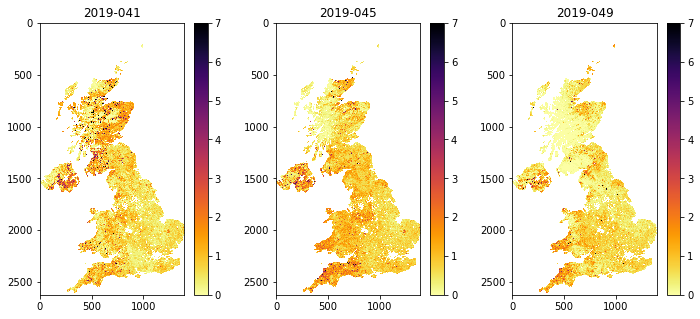

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3,figsize=(12,5))
axs = axs.flatten()
for i in range(data.shape[0]):
    im = axs[i].imshow(data[i],vmax=7,\
                cmap=plt.cm.inferno_r,interpolation='nearest')
    fig.colorbar(im, ax=axs[i])
    axs[i].set_title(bnames[i])

## A year of data

A convenient feature of `Modis.get_modis` is that we can use wildcards for specifying dates. 

So, to get a year of LAI data for Luxembourg, we can specify `doys = "*"`. Note that we could have chosen any location, but we select a small country to make the running more feasible in a practical session.

If the data are already downloaded into the local cache, it should not take too long to form the time series. It will need to generate the VRT files for how every many files and tile you have requested, so that may take some tens of minutes, even if the HDF files are already generated.

If you are attempting to get data not already in the cache, it will take some considerable time to download these datasets for whole years, for multiple tiles. 

If you want to download a dataset that is not covered in these notebooks, you are of course welcome to do so, but plan your work ahead of time, and try to pre-download the data before attempting any processing. In such a case, you should take some code such as that below and paste it into a Python file and run that as a Python script from a command line. You should make sure you set:

    'verbose' : True
    
in the `kwargs` dictionary. An example script you can modify is given in [geog0111/get_lai.py](geog0111/get_lai.py).

In [11]:
import gdal
from geog0111.modis import Modis
import matplotlib.pyplot as plt

kwargs = {
    'tile'      :    ['h17v03','h18v03','h17v04','h18v04'],
    'product'   :    'MCD15A3H',
    'year'      :    2019,
    'doy'       :    "*"
}

'''
We will gather the data for the year, 
tiles and product that we are interested in into a VRT file:
'''
modis = Modis(**kwargs)
ifiles = modis.get_modis(kwargs['year'],kwargs['doy'],step=4)

In [12]:
ifiles.keys()

dict_keys(['FparExtra_QC', 'FparLai_QC', 'FparStdDev_500m', 'Fpar_500m', 'LaiStdDev_500m', 'Lai_500m', 'bandnames'])

We can apply `warp_args` to crop the dataset:

In [13]:
import gdal

warp_args = {
    'dstNodata'     : 255,
    'format'        : 'MEM',
    'cropToCutline' : True,
    'cutlineWhere'  : "FIPS='LU'",
    'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}

sds = ['Lai_500m','LaiStdDev_500m','FparLai_QC']

# loop over SDS sets and read into dictionary
mfiles = {'bandnames':ifiles['bandnames']}
for s in sds:
    g = gdal.Warp("",ifiles[s],**warp_args)
    mfiles[s] = g.ReadAsArray()
# scale
mfiles['Lai_500m'] = mfiles['Lai_500m'] * 0.1
mfiles['LaiStdDev_500m'] = mfiles['LaiStdDev_500m'] * 0.1

We can now plot the data on sub-plots:

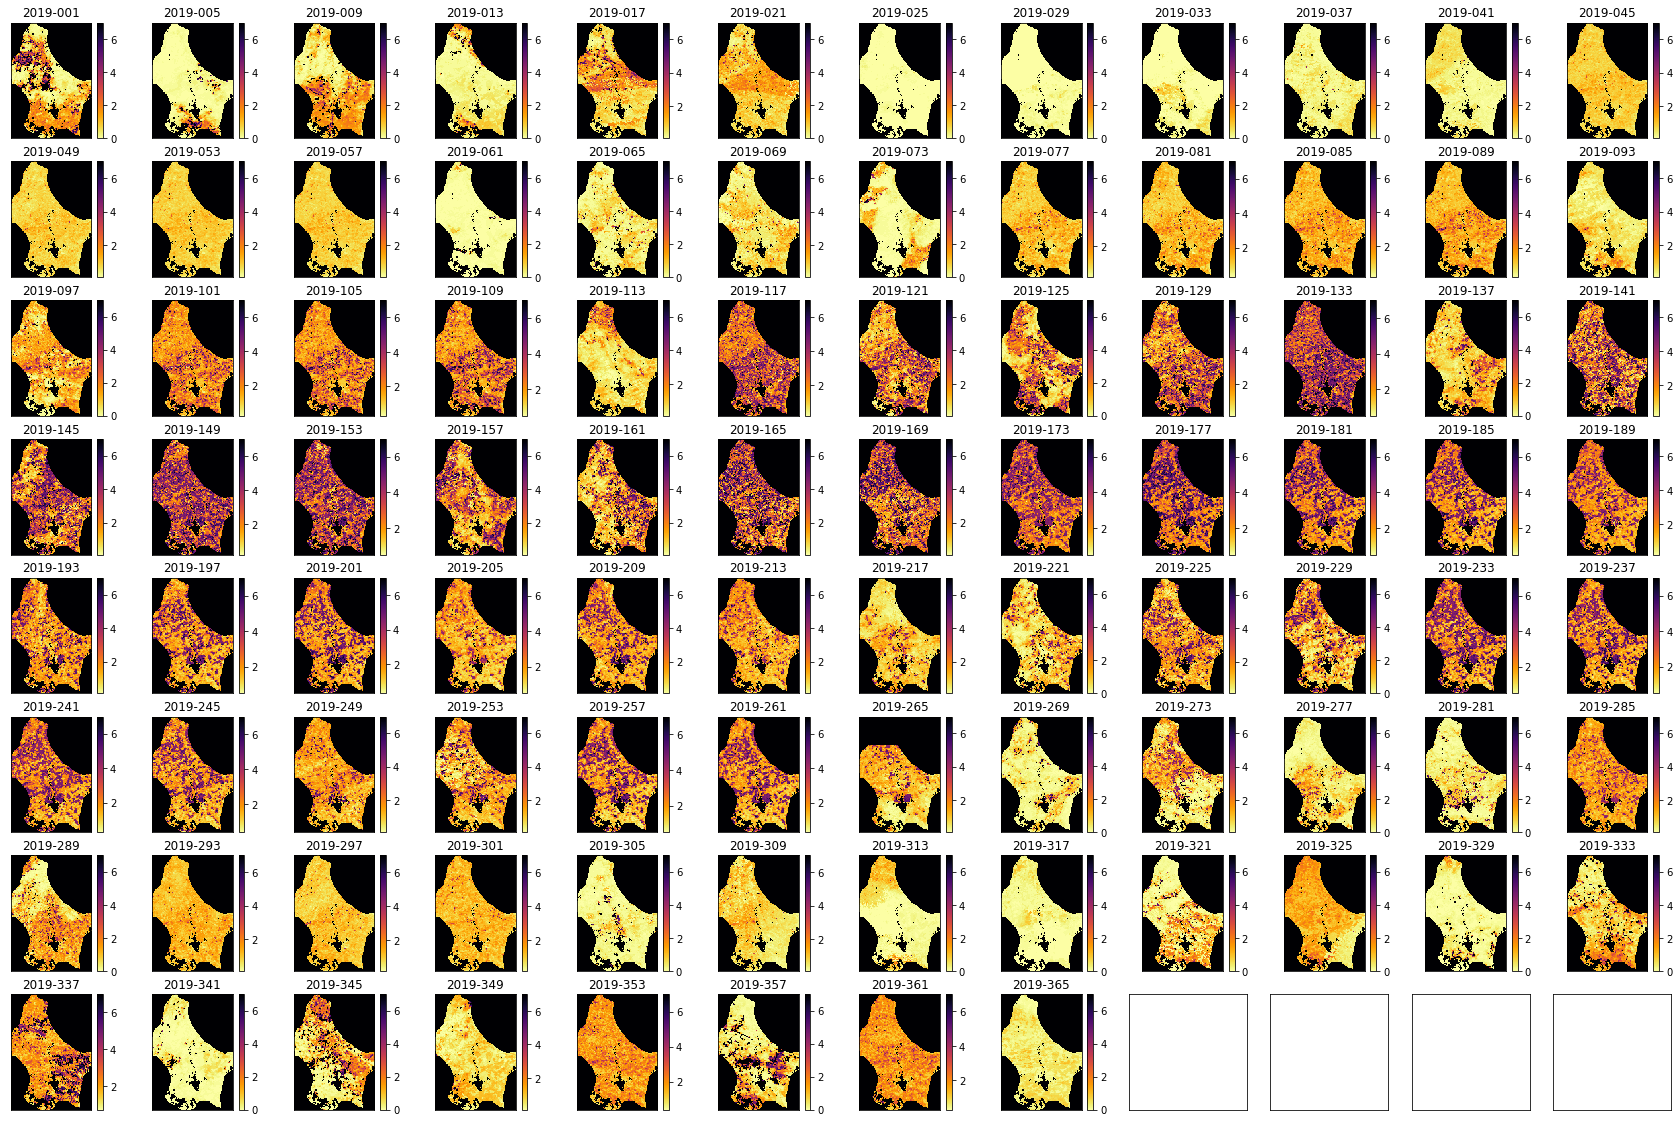

In [14]:
import matplotlib.pyplot as plt

shape=(8,12)
x_size,y_size=(30,20)

fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
axs = axs.flatten()
plt.setp(axs, xticks=[], yticks=[])

for i in range(mfiles['Lai_500m'].shape[0]):
    im = axs[i].imshow(mfiles['Lai_500m'][i],vmax=7,cmap=plt.cm.inferno_r,\
                       interpolation='nearest')
    axs[i].set_title(mfiles['bandnames'][i])
    fig.colorbar(im, ax=axs[i])

### Plotting time series

We might now want to plot some time series.

First, extract the `doy` from `mfiles['bandnames']`:

In [15]:
print(mfiles['bandnames'])

['2019-001', '2019-005', '2019-009', '2019-013', '2019-017', '2019-021', '2019-025', '2019-029', '2019-033', '2019-037', '2019-041', '2019-045', '2019-049', '2019-053', '2019-057', '2019-061', '2019-065', '2019-069', '2019-073', '2019-077', '2019-081', '2019-085', '2019-089', '2019-093', '2019-097', '2019-101', '2019-105', '2019-109', '2019-113', '2019-117', '2019-121', '2019-125', '2019-129', '2019-133', '2019-137', '2019-141', '2019-145', '2019-149', '2019-153', '2019-157', '2019-161', '2019-165', '2019-169', '2019-173', '2019-177', '2019-181', '2019-185', '2019-189', '2019-193', '2019-197', '2019-201', '2019-205', '2019-209', '2019-213', '2019-217', '2019-221', '2019-225', '2019-229', '2019-233', '2019-237', '2019-241', '2019-245', '2019-249', '2019-253', '2019-257', '2019-261', '2019-265', '2019-269', '2019-273', '2019-277', '2019-281', '2019-285', '2019-289', '2019-293', '2019-297', '2019-301', '2019-305', '2019-309', '2019-313', '2019-317', '2019-321', '2019-325', '2019-329', '20

In [16]:
# convert to 1 by splitting the string
test = '2019-001'
int(test.split('-')[1])

1

In [17]:
doy = [int(i.split('-')[1]) for i in mfiles['bandnames']]
print(doy)

[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 313, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361, 365]


It is interesting to see a set of sub-plots for a range of pixel locations. We can follow tghe approach we have taken to sub-plots previously, but now we want to make use of the 2D nature of the sub-plot `axs` variable (recall that previously we have flattened this to a 1D representation).

We will define a sub-plot shape: `shape=(10,10)` and a starting pixel `pixel = (100,70)`. We will then loop in row and column to produce the sub-plots:

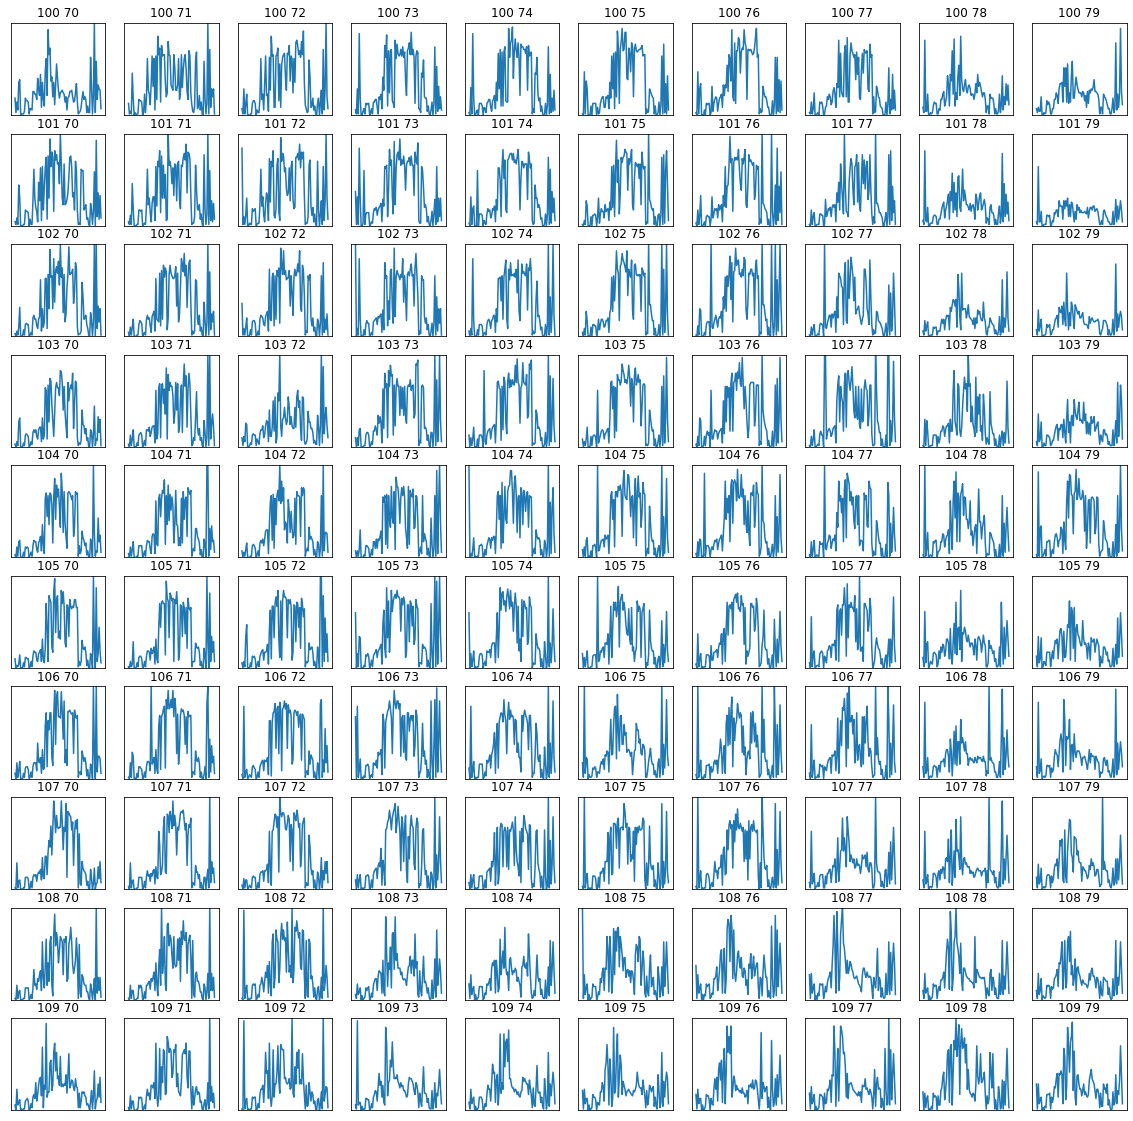

In [18]:
import matplotlib.pyplot as plt

x_size,y_size=(20,20)

shape=(10,10)
fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
plt.setp(axs, xticks=[], yticks=[])

pixel = (100,70)
x = doy

for i in range(shape[0]):
    p0 = pixel[0] + i
    for j in range(shape[1]):
        p1 = pixel[1] + j
        im = axs[i,j].plot(x,mfiles['Lai_500m'][:,p0,p1])
        axs[i,j].set_title(f'{p0} {p1}')
        # ensure the same scale for all
        axs[i,j].set_ylim(0,7)

#### Exercise 2

* Write a function called `modis_annual_dataset`that takes `year`,`tile` and `product` and `step` and returns a dictionary of appropriate MODIS datasets. 

* Write another function `get_modis_annual` that takes the dictionary of appropriate MODIS datasets. and generates a dictionary of MODIS data values, filtered according to information of the form:

        warp_args = {
            'dstNodata'     : 255,
            'format'        : 'MEM',
            'cropToCutline' : True,
            'cutlineWhere'  : "FIPS='LU'",
            'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
        }

        sds = ['Lai_500m','LaiStdDev_500m','FparLai_QC']

* Write a third function `modis_annual` that combines these two functions.
* Test your code and plot some results

## Uncertainty and weighting

The full set of SDS available is 

    ['Fpar_500m',
     'Lai_500m',
     'FparLai_QC',
     'FparExtra_QC',
     'FparStdDev_500m',
     'LaiStdDev_500m']
     
We should always examine any uncertainty information available when trying to interpret a dataset. In this exercise, we will take the uncertainty, defined as a standard deviation, and generate a weight from this in the form:

    W  = 1/(std * std)
    
where std is the uncertainty. Where this weighting is high, we can put more emphasis on the reliability of the data than when it is low.

First then, read all SDS:

In [23]:
import gdal
import matplotlib.pyplot as plt
from geog0111.modis_annual import modis_annual

warp_args = {
  'dstNodata'     : 255,
  'format'        : 'MEM',
  'cropToCutline' : True,
  'cutlineWhere'  : "FIPS='LU'",
  'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
}
sds     = ['Lai_500m','LaiStdDev_500m','FparLai_QC']
tile    = ['h17v03','h18v03','h17v04','h18v04']
product = 'MCD15A3H'
year    = 2019
step    = 4
    
mfiles = modis_annual(year,tile,product,sds=sds,step=step,warp_args=warp_args)

print(mfiles.keys())


dict_keys(['bandnames', 'Lai_500m', 'LaiStdDev_500m', 'FparLai_QC'])


In [24]:
# scale
mfiles['Lai_500m'] = mfiles['Lai_500m'] * 0.1
mfiles['LaiStdDev_500m'] = mfiles['LaiStdDev_500m'] * 0.1

There is a feature in the `LaiStdDev_500m` dataset where some pixels have apparently zero uncertainty. Indeed, all LAI values with an uncertainty under 1.0 seem suspect as individual values. So we treat them hear, to set all values less than 1 to 1.

We know that LAI values over 10 (100 * 0.1) are invalid, so we should make sure these are also weighted zero:

In [25]:
import numpy as np

weight = np.zeros_like(mfiles['LaiStdDev_500m'])
std = mfiles['LaiStdDev_500m']

# fix low values
std[std<1.0] = 1.0

mask = (std > 0)
weight[mask] = 1./(std[mask]**2)

weight[mfiles['Lai_500m'] > 10] = 0.
weight[mfiles['LaiStdDev_500m']==0] = 0.
# look at some stats
print(weight.min(),weight.max())

0.0 1.0


We can now go ahead and plot the dataset and the weights. We switch to a greyscale colourmap to make the interpretation of numbers easier.

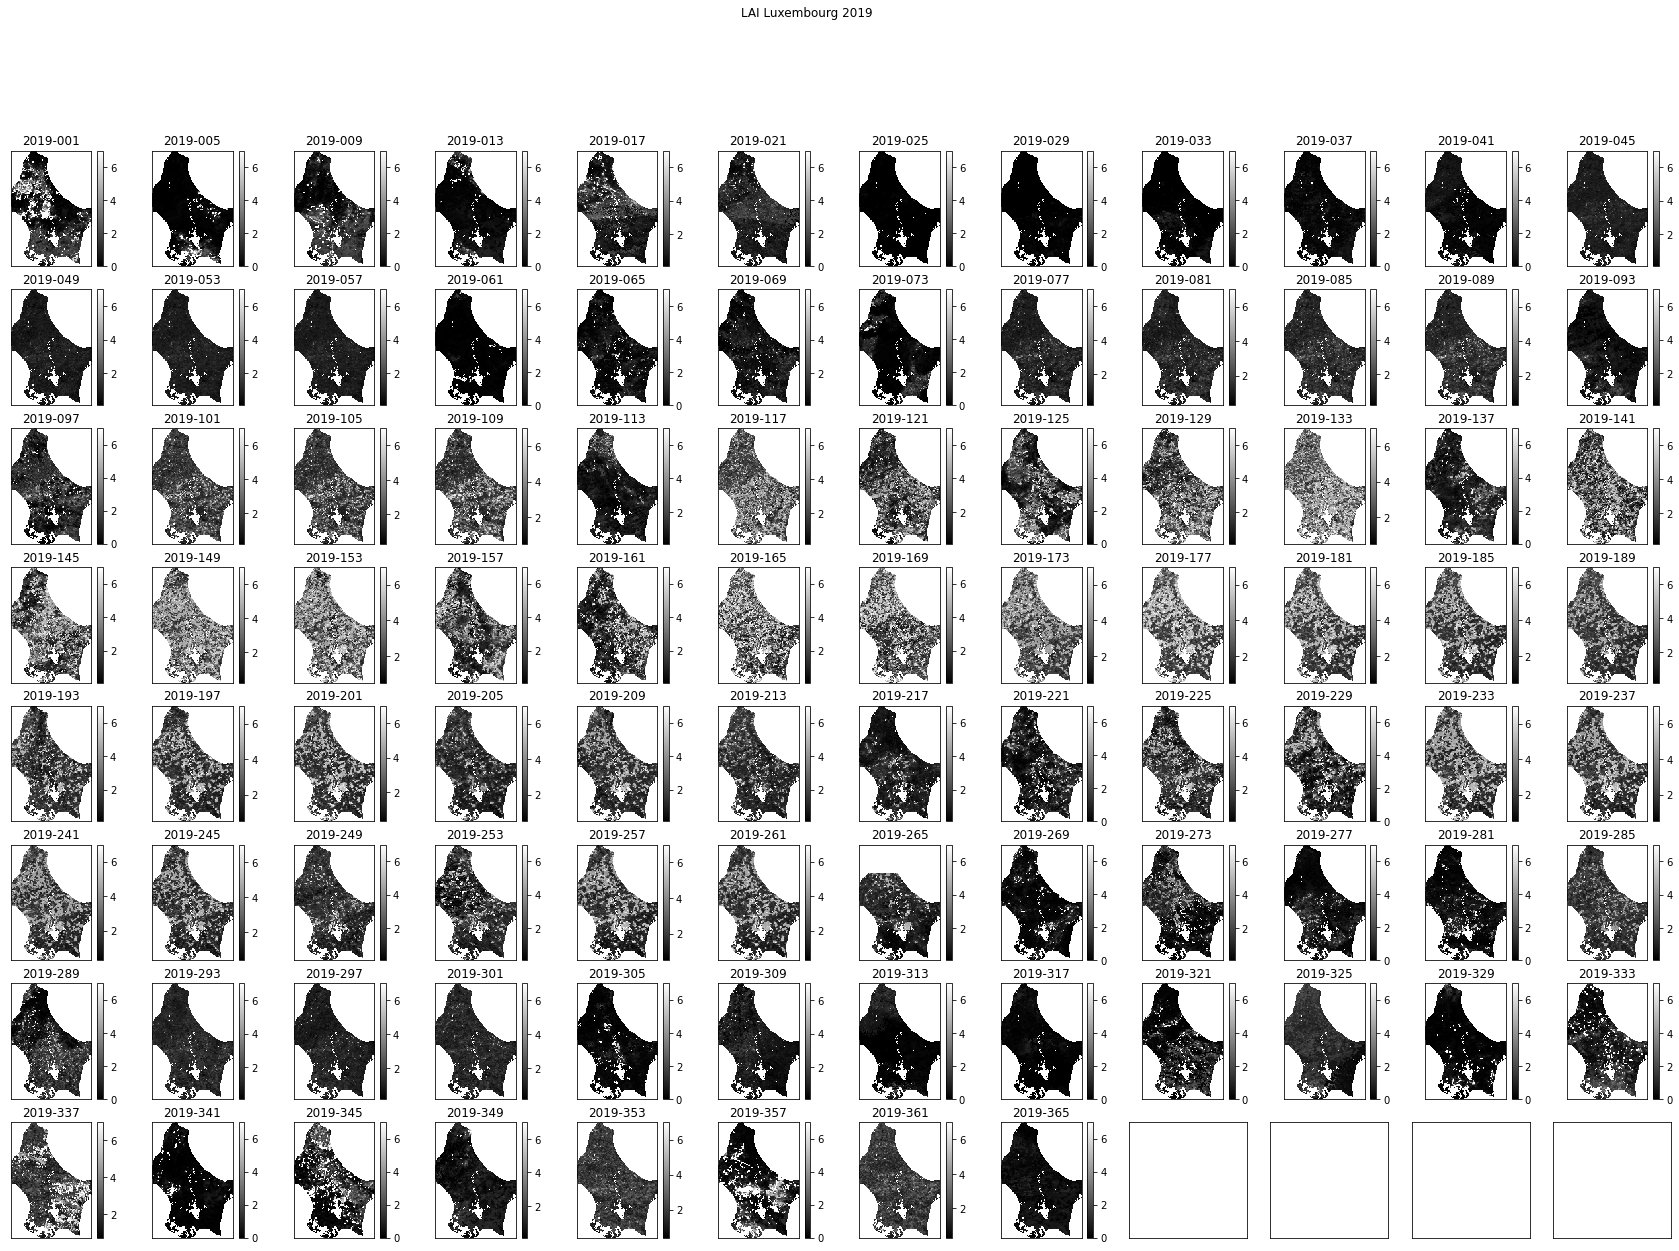

In [26]:
# produce image plots of the both quantities
import matplotlib.pyplot as plt

shape=(8,12)
x_size,y_size=(30,20)

fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
axs = axs.flatten()
plt.setp(axs, xticks=[], yticks=[])
fig.suptitle("LAI Luxembourg 2019")
for i in range(mfiles['Lai_500m'].shape[0]):
    im = axs[i].imshow(mfiles['Lai_500m'][i],vmax=7,cmap=plt.cm.gray,\
                       interpolation='nearest')
    axs[i].set_title(mfiles['bandnames'][i])
    fig.colorbar(im, ax=axs[i])

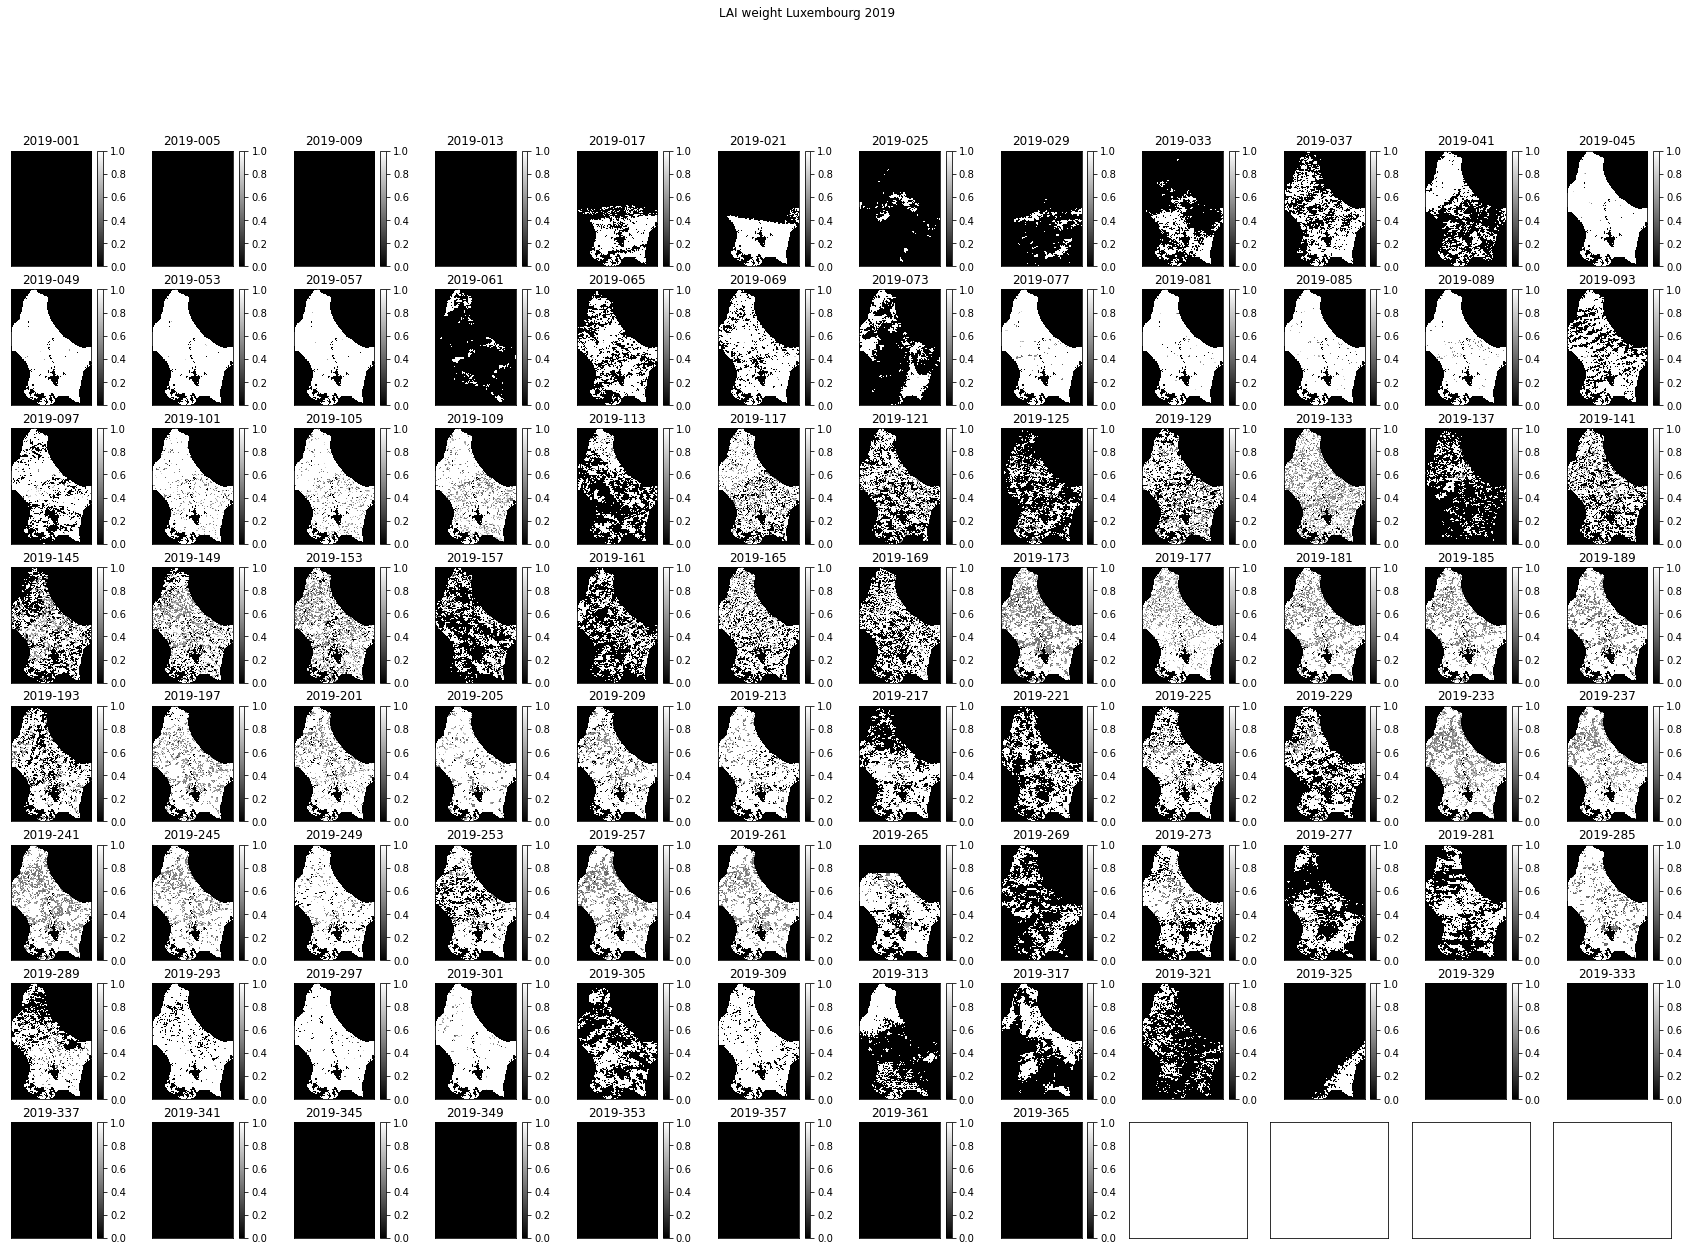

In [27]:
# Plot the weight
import matplotlib.pyplot as plt

shape=(8,12)
x_size,y_size=(30,20)

fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
axs = axs.flatten()
plt.setp(axs, xticks=[], yticks=[])
fig.suptitle("LAI weight Luxembourg 2019")

for i in range(mfiles['Lai_500m'].shape[0]):
    im = axs[i].imshow(weight[i],vmax=1,cmap=plt.cm.gray,\
                       interpolation='nearest')
    axs[i].set_title(mfiles['bandnames'][i])
    fig.colorbar(im, ax=axs[i])

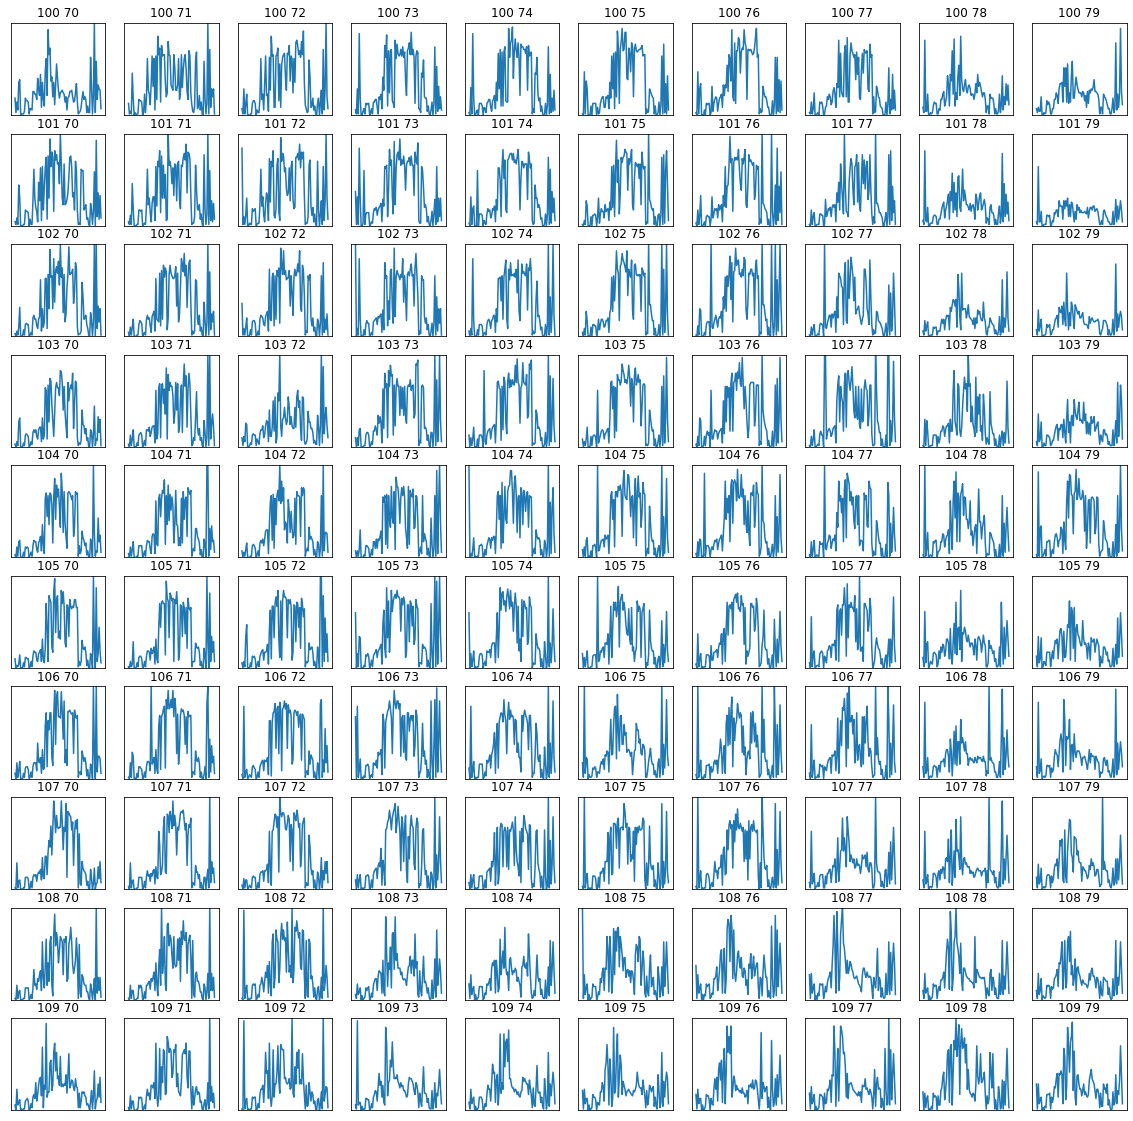

In [28]:
# LAI time series
import matplotlib.pyplot as plt
doy = [int(i.split('-')[1]) for i in mfiles['bandnames']]

x_size,y_size=(20,20)

shape=(10,10)
fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
plt.setp(axs, xticks=[], yticks=[])

pixel = (100,70)
x = doy

for i in range(shape[0]):
    p0 = pixel[0] + i
    for j in range(shape[1]):
        p1 = pixel[1] + j
        im = axs[i,j].plot(x,mfiles['Lai_500m'][:,p0,p1])
        axs[i,j].set_title(f'{p0} {p1}')
        # ensure the same scale for all
        axs[i,j].set_ylim(0,7)

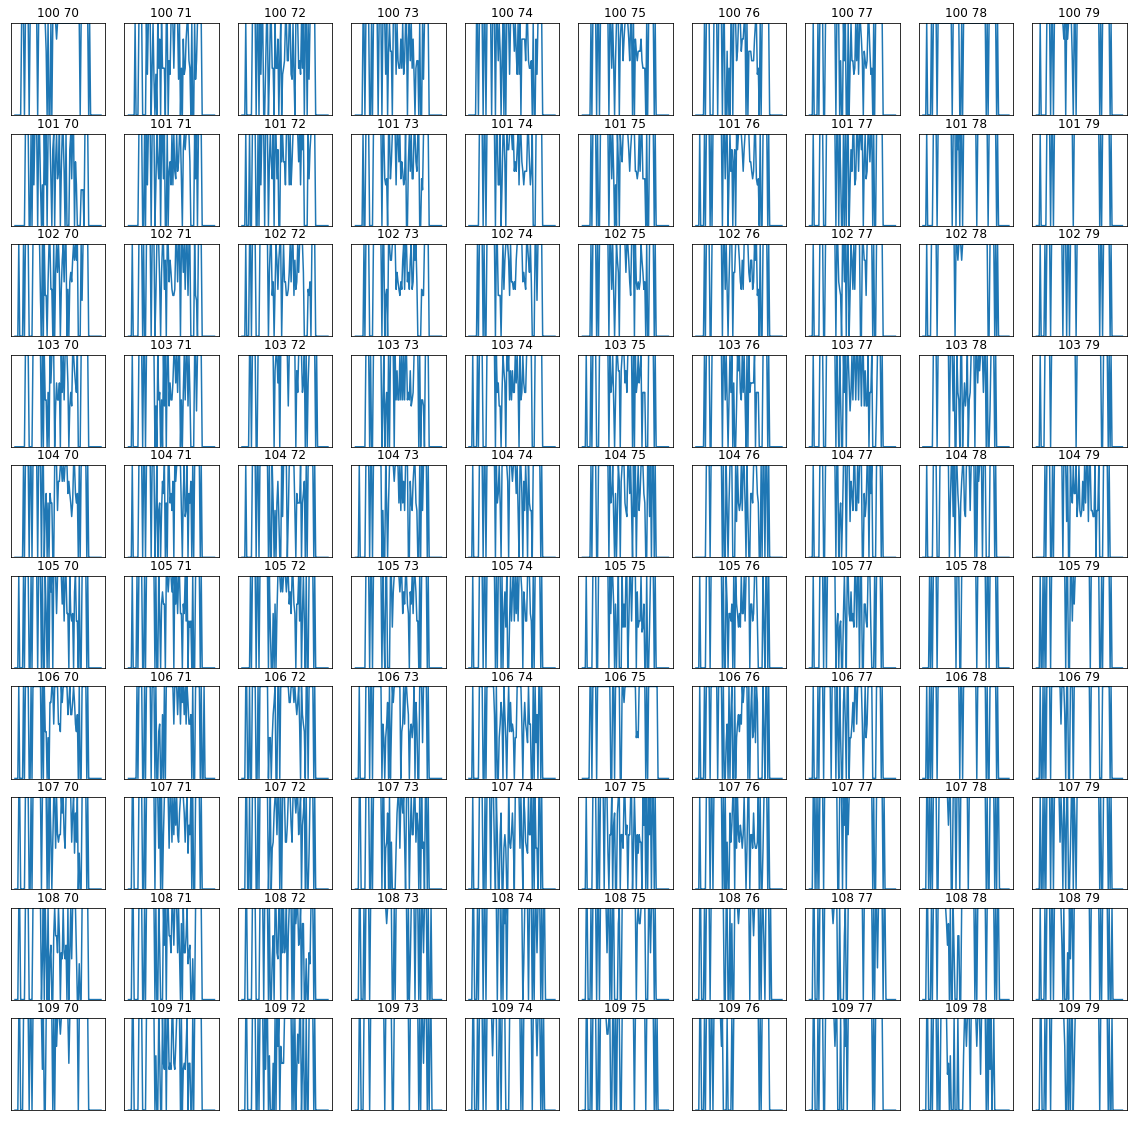

In [29]:
# weight time series plots 
import matplotlib.pyplot as plt
doy = [int(i.split('-')[1]) for i in mfiles['bandnames']]

x_size,y_size=(20,20)

shape=(10,10)
fig, axs = plt.subplots(*shape,figsize=(x_size,y_size))
plt.setp(axs, xticks=[], yticks=[])

pixel = (100,70)
x = doy

for i in range(shape[0]):
    p0 = pixel[0] + i
    for j in range(shape[1]):
        p1 = pixel[1] + j
        im = axs[i,j].plot(x,weight[:,p0,p1])
        axs[i,j].set_title(f'{p0} {p1}')
        # ensure the same scale for all
        axs[i,j].set_ylim(0,1)

We can look at an individual plot now, and use the weights for error bars.

In this case, we want to convert the array `weight` to an array `error`, applying the opposite of what we did above to get standard deviation, and multiplying by [1.96](https://en.wikipedia.org/wiki/1.96).

We want to avoid the division `1/0`, so we first build an array the same as weight, but fiulled with zero values:

    error = np.zeros_like(weight)
    
and then only do the division for the mask `weight>0`:

    error[weight>0] = np.sqrt(1./(weight[weight>0] )) * 1.97

Text(0, 0.5, 'LAI')

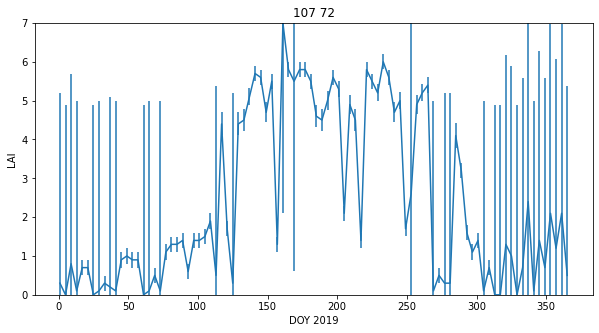

In [30]:
import matplotlib.pyplot as plt

error = np.zeros_like(weight)
error[weight>0] = np.sqrt(1./(weight[weight>0] )) * 1.97

doy = [int(i.split('-')[1]) for i in mfiles['bandnames']]
p0,p1 = (107,72)
x_size,y_size=(10,5)

shape=(10,10)
fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))

pixel = (100,70)
x = doy

axs.errorbar(x,mfiles['Lai_500m'][:,p0,p1],yerr=error[:,p0,p1]/10)
axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')

We might question the validity of some of the LAI uncertainty here: we expect LAI to have a smnooth trajectory in time, but that is clearly not always the case here. However, they provide a traceable estimate of the reliability of each individual measurement and are useful in that respect.

#### Exercise 3

* Write a function `get_lai_data` that takes as argument:
    
        year : integer year
        tile : list of tiles to process
        fips : country fips code (e.g. BE for Belgium)
        
  and returns the annual LAI, standard deviation and day of year

* test your code for Belgium for 2018 for tiles `['h17v03','h18v03','h17v04','h18v04']`
* show the shape of the arrays returned

Hint: You may find it useful to use `geog0111.modis_annual`


## Summary

We now know how to combine geospatial data in both space and time VRT files using `gdal`. Remember that we can also do such things using `numpy`, but if we are able to keep the geospatial information and other metadata in a `gdal` file, so much the better. We have seen how to write the dataset to a portable file format such as GeoTiff.

We have seen that some datasets such as the MODIS LAI product come with a per-pixel estimate of uncertainty. We have investigated this data field and used it to provide a weighting to associate with the reliability of each pixel. We have written a function `modis_annual` that uses a yaml database to see if it needs to reconstruct a large annual datafile.

